# Imports

In [1]:
import numpy as np
import pandas as pd
import pkg_resources
import itertools
import shap
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

from lightgbmlss.model import *
from lightgbmlss.distributions.Gaussian import Gaussian
from lightgbmlss.datasets.data_loader import load_simulated_data

# Data

In [2]:
# The data is a simulated Gaussian as follows, where x is the only true feature and all others are noise variables
    # loc = 10
    # scale = 1 + 4*((0.3 < x) & (x < 0.5)) + 2*(x > 0.7)

train, test = load_simulated_data()

X_train, y_train = train.iloc[:,1:],train.iloc[:,0]
X_test, y_test = test.iloc[:,1:],test.iloc[:,0]

dtrain = lgb.Dataset(X_train, label=y_train)

# Distribution and Quantile Selection

In [3]:
distribution = Gaussian                   # Estimates both location and scale parameters of the Gaussian simultaneously.
distribution.stabilize = "None"           # Option to stabilize Gradient/Hessian. Options are "None", "MAD", "L2"
quant_sel = [0.05, 0.95]

# Hyper-Parameter Optimization

In [4]:
np.random.seed(123)

# Specifies the parameters and their value range. The structure is as follows: "hyper-parameter": [lower_bound, upper_bound]. Currently, only the following hyper-parameters can be optimized:

params = {"boosting": "gbdt",
          "eta": [1e-5, 1], 
          "max_depth": [1, 10],
          "num_leaves": [255, 255],           # set to default value for this example
          "min_data_in_leaf": [20, 20],       # set to default value for this example
          "lambda_l1": [0, 0],                # set to default value for this example
          "lambda_l2": [0, 0],                # set to default value for this example
          "min_gain_to_split": [1e-8 , 40],
          "min_sum_hessian_in_leaf":[1, 500],
          "subsample": [0.2, 1.0],
          "feature_fraction": [0.2, 1.0]
         }

opt_params = lightgbmlss.hyper_opt(params,
                                   dtrain=dtrain,
                                   dist=distribution,
                                   num_boost_round=500,       # Number of boosting iterations.
                                   max_minutes=10,            # Time budget in minutes, i.e., stop study after the given number of minutes.
                                   n_trials=None,             # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                                   silence=True)              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.

C:\Users\Alexander\.julia\v0.6\Conda\deps\usr\envs\lightgbmlss\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


0it [00:00, ?it/s]

Hyper-Parameter Optimization successfully finished.
Number of finished trials:  273
Best trial:
  Value: 1457.3251856065829
  Params: 
    eta: 0.23288200671655696
    max_depth: 3
    num_leaves: 255
    min_data_in_leaf: 20
    lambda_l1: 0
    lambda_l2: 0
    min_gain_to_split: 0.00040114893098731295
    min_sum_hessian_in_leaf: 130
    subsample: 0.7422765687028476
    feature_fraction: 0.8526598072228596
    opt_rounds: 24


# Model Training

In [5]:
np.random.seed(123)

n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyper-parameters
lightgbmlss_model = lightgbmlss.train(opt_params,
                                      dtrain,
                                      dist=distribution,
                                      num_boost_round=n_rounds)

# Prediction

In [6]:
# Number of samples to draw from predicted distribution
n_samples=100

# Using predicted distributional parameters, sample from distribution
pred_y = lightgbmlss.predict(lightgbmlss_model, 
                             dtest=X_test, 
                             dist=distribution,
                             pred_type="response",
                             n_samples=n_samples, 
                             seed=123)

# Using predicted distributional parameters, calculate quantiles
pred_quantiles = lightgbmlss.predict(lightgbmlss_model, 
                                     dtest=X_test, 
                                     dist=distribution,
                                     pred_type="quantiles", 
                                     quantiles=quant_sel)


# Returns predicted distributional parameters
pred_params = lightgbmlss.predict(lightgbmlss_model, 
                                  dtest=X_test, 
                                  dist=distribution,
                                  pred_type="parameters")

In [7]:
pred_y.head()

,y_pred_sample_0,y_pred_sample_1,y_pred_sample_2,y_pred_sample_3,y_pred_sample_4,y_pred_sample_5,y_pred_sample_6,y_pred_sample_7,y_pred_sample_8,y_pred_sample_9,...,y_pred_sample_90,y_pred_sample_91,y_pred_sample_92,y_pred_sample_93,y_pred_sample_94,y_pred_sample_95,y_pred_sample_96,y_pred_sample_97,y_pred_sample_98,y_pred_sample_99
0,6.838700,12.782955,10.744343,5.638237,8.285628,14.649556,3.011706,8.712797,13.549441,7.463354,...,13.219177,6.320115,10.453424,13.298101,8.980767,12.879323,6.841732,6.045816,11.019506,8.854730
1,7.035625,12.565739,10.669159,5.918800,8.381745,14.302293,3.475262,8.779152,13.278824,7.616759,...,12.971569,6.553171,10.398509,13.044995,9.028453,12.655393,7.038447,6.297983,10.925151,8.911198
2,8.917561,11.106709,10.355930,8.475456,9.450435,11.794139,7.508158,9.607753,11.388990,9.147609,...,11.267360,8.726577,10.248790,11.296426,9.706441,11.142199,8.918678,8.625559,10.457267,9.660024
3,5.020665,14.330830,11.137863,3.140446,7.286911,17.254385,-0.973347,7.955962,15.531335,5.999027,...,15.014060,4.208435,10.682212,15.137674,8.375670,14.481765,5.025415,3.778815,11.568835,8.178265
4,6.563263,13.220730,10.937519,5.218765,8.183799,15.311291,2.277095,8.662221,14.079181,7.262865,...,13.709291,5.982458,10.611694,13.797684,8.962343,13.328660,6.566660,5.675247,11.245696,8.821184


In [8]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,5.242827,14.630770
1,5.550938,14.284815
2,8.329834,11.787221
3,2.521137,17.224962
4,4.775913,15.290251


In [9]:
pred_params.head()

,location,scale
0,9.936798,2.853732
1,9.917877,2.654910
2,10.058528,1.050971
3,9.873049,4.469645
4,10.033082,3.196132


# SHAP Interpretability

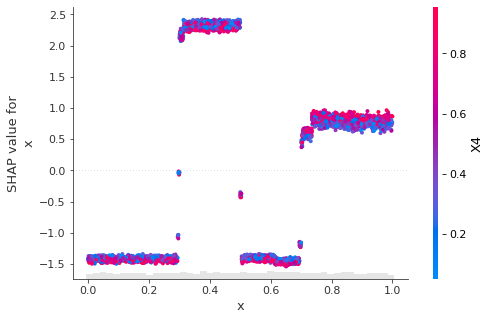

In [10]:
# Partial Dependence Plot of how x acts on variance 
lightgbmlss.plot(lightgbmlss_model, 
                X_test, 
                parameter="scale",
                feature="x", 
                plot_type="Partial_Dependence")

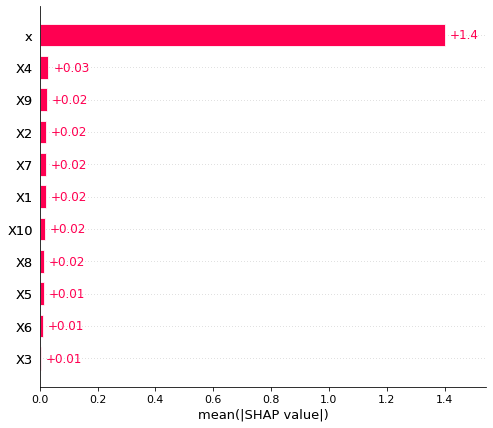

In [11]:
# Feature Importance of features on scale parameter
lightgbmlss.plot(lightgbmlss_model, 
                X_test, 
                parameter="scale", 
                plot_type="Feature_Importance")

# Plot of Actual vs. Predicted Quantiles

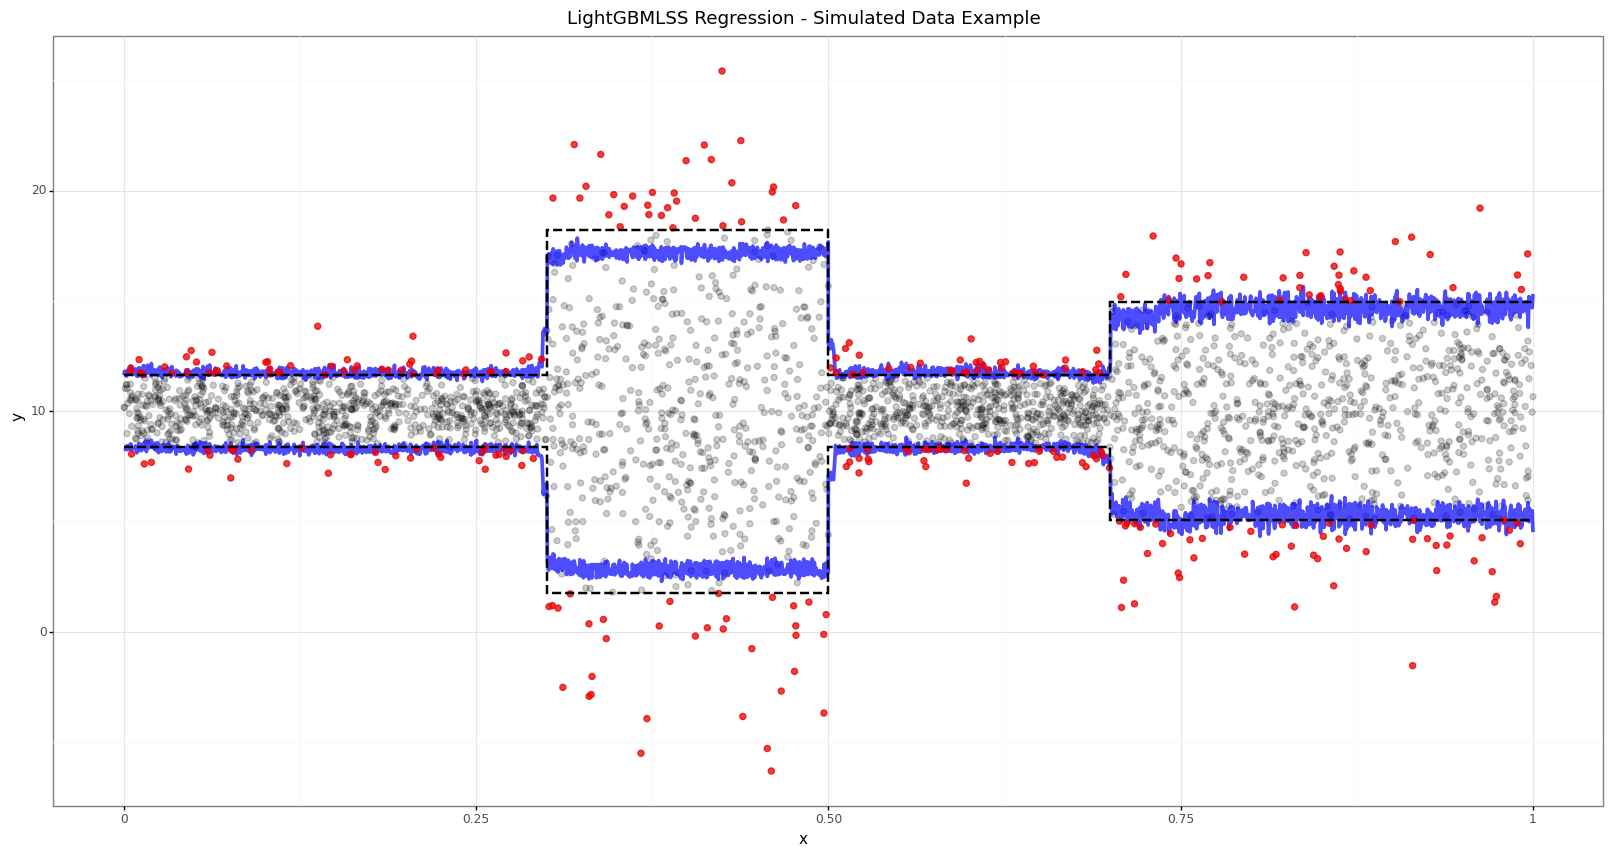

<ggplot: (113366692527)>

In [12]:
np.random.seed(123)

###
# Actual Quantiles
###
q1 = norm.ppf(quant_sel[0], loc = 10, scale = 1 + 4*((0.3 < test["x"].values) & (test["x"].values < 0.5)) + 2*(test["x"].values > 0.7))
q2 = norm.ppf(quant_sel[1], loc = 10, scale = 1 + 4*((0.3 < test["x"].values) & (test["x"].values < 0.5)) + 2*(test["x"].values > 0.7))
test["quant"] = np.where(test["y"].values < q1, 0, np.where(test["y"].values < q2, 1, 2))
test["alpha"] = np.where(test["y"].values <= q1, 1, np.where(test["y"].values >= q2, 1, 0))
df_quantiles = test[test["alpha"] == 1]

# Lower Bound
yl = list(set(q1))
yl.sort()
yl = [yl[2],yl[0],yl[2],yl[1],yl[1]]
sfunl = pd.DataFrame({"x":[0, 0.3, 0.5, 0.7, 1],
                      "y":yl})

# Upper Bound
yu = list(set(q2))
yu.sort()
yu = [yu[0],yu[2],yu[0],yu[1],yu[1]]
sfunu = pd.DataFrame({"x":[0, 0.3, 0.5, 0.7, 1],
                      "y":yu})



###
# Forecasted Quantiles
###
test["lb"] = pred_quantiles.iloc[:,0]
test["ub"] = pred_quantiles.iloc[:,1]



###
# Plot
###
(ggplot(test,
        aes("x",
            "y")) + 
 geom_point(alpha = 0.2, color = "black", size = 2) + 
 theme_bw() + 
 theme(legend_position="none",
       plot_title = element_text(hjust = 0.5)) +
 labs(title = "LightGBMLSS Regression - Simulated Data Example")  + 
 geom_line(aes("x",
               "ub"),
           size = 1.5,
           color = "blue", 
           alpha = 0.7) + 
 geom_line(aes("x",
               "lb"),
           size = 1.5,
           color = "blue", 
           alpha = 0.7) + 
 geom_point(df_quantiles,
            aes("x",
                "y"), 
            color = "red", 
            alpha = 0.7,
            size = 2) + 
 geom_step(sfunl,
           aes("x",
               "y"), 
           size = 1, 
           linetype = "dashed")  + 
 geom_step(sfunu,
           aes("x",
               "y"), 
           size = 1, 
           linetype = "dashed") 
)